In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, mean, count, when
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from scipy.stats import ttest_ind
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession.builder.appName("CookieCatsEDA").getOrCreate()

# Load the dataset
sdf = spark.read.csv("cookie_cats.csv", header=True, inferSchema=True)

# Show the schema and first few rows
sdf.printSchema()
sdf.show(5)

# Handle missing values
sdf = sdf.dropna()

# Remove duplicates
sdf = sdf.dropDuplicates()

# Show the number of rows after cleaning
print(f"Number of rows after cleaning: {sdf.count()}")

# Check summary statistics
sdf.describe().show()


root
 |-- userid: integer (nullable = true)
 |-- version: string (nullable = true)
 |-- sum_gamerounds: integer (nullable = true)
 |-- retention_1: boolean (nullable = true)
 |-- retention_7: boolean (nullable = true)

+------+-------+--------------+-----------+-----------+
|userid|version|sum_gamerounds|retention_1|retention_7|
+------+-------+--------------+-----------+-----------+
|   116|gate_30|             3|      false|      false|
|   337|gate_30|            38|       true|      false|
|   377|gate_40|           165|       true|      false|
|   483|gate_40|             1|      false|      false|
|   488|gate_40|           179|       true|       true|
+------+-------+--------------+-----------+-----------+
only showing top 5 rows

Number of rows after cleaning: 90189
+-------+------------------+-------+------------------+
|summary|            userid|version|    sum_gamerounds|
+-------+------------------+-------+------------------+
|  count|             90189|  90189|           

In [3]:
#EDA (Exploratory Data Analysis)
# Group by 'version' and calculate average game rounds and retention rates
from pyspark.sql.functions import col, mean, count, when
eda_stats = sdf.groupBy("version").agg(
    mean("sum_gamerounds").alias("avg_game_rounds"),
    (mean(when(col("retention_1") == True, 1).otherwise(0)) * 100).alias("retention_1_rate"),
    (mean(when(col("retention_7") == True, 1).otherwise(0)) * 100).alias("retention_7_rate")
)

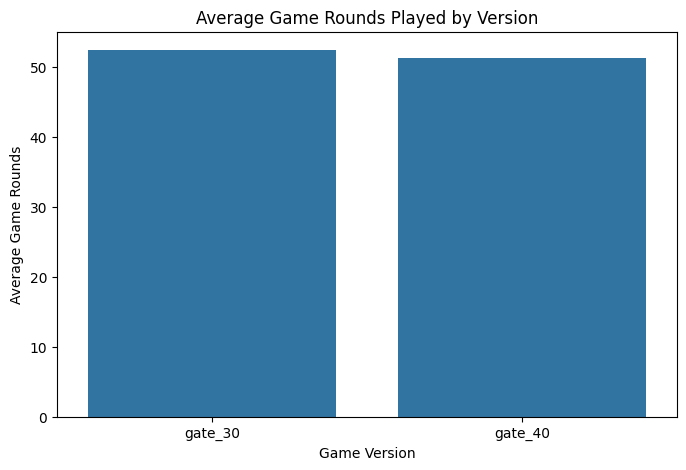

In [6]:
# Convert to Pandas DataFrame for visualization
eda_df = eda_stats.toPandas()

# Plot: Average Game Rounds
plt.figure(figsize=(8, 5))
sns.barplot(x="version", y="avg_game_rounds", data=eda_df)
plt.title("Average Game Rounds Played by Version")
plt.xlabel("Game Version")
plt.ylabel("Average Game Rounds")
plt.show()

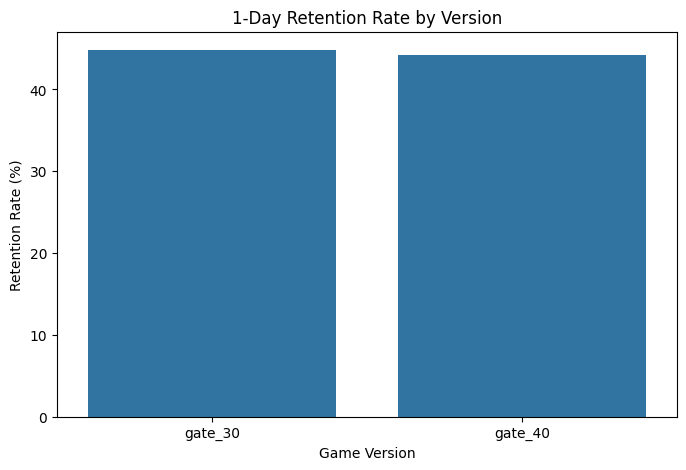

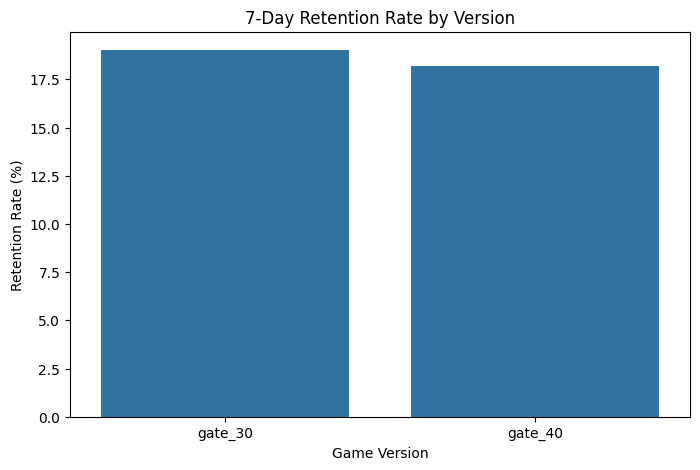

In [7]:
# Plot: Retention Rates
plt.figure(figsize=(8, 5))
sns.barplot(x="version", y="retention_1_rate", data=eda_df)
plt.title("1-Day Retention Rate by Version")
plt.xlabel("Game Version")
plt.ylabel("Retention Rate (%)")
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x="version", y="retention_7_rate", data=eda_df)
plt.title("7-Day Retention Rate by Version")
plt.xlabel("Game Version")
plt.ylabel("Retention Rate (%)")
plt.show()

In [8]:
#Hypothesis Testing
# Convert Spark DataFrame to Pandas for hypothesis testing
df_pandas = sdf.toPandas()

# Split by version
gate_30 = df_pandas[df_pandas['version'] == 'gate_30']
gate_40 = df_pandas[df_pandas['version'] == 'gate_40']

# Perform t-tests
t_test_gamerounds = ttest_ind(gate_30['sum_gamerounds'], gate_40['sum_gamerounds'], equal_var=False)
t_test_retention_1 = ttest_ind(gate_30['retention_1'].astype(int), gate_40['retention_1'].astype(int), equal_var=False)
t_test_retention_7 = ttest_ind(gate_30['retention_7'].astype(int), gate_40['retention_7'].astype(int), equal_var=False)

In [9]:
# Display results
print(f"P-value for game rounds: {t_test_gamerounds.pvalue}")
print(f"P-value for 1-day retention: {t_test_retention_1.pvalue}")
print(f"P-value for 7-day retention: {t_test_retention_7.pvalue}")

# 6. Conclusions and Recommendations
if t_test_retention_7.pvalue < 0.05:
    print("There is a significant difference in 7-day retention between the two versions.")
else:
    print("No significant difference in 7-day retention between the two versions.")

P-value for game rounds: 0.37592438409326157
P-value for 1-day retention: 0.07441443713953834
P-value for 7-day retention: 0.001556530181006652
There is a significant difference in 7-day retention between the two versions.
